<a href="https://colab.research.google.com/github/lulmer/DA-RNN_for_timeseries/blob/master/DA_RNN_CAC40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DA RNN

Google Drive Mount

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Hyper-parameters settings

In [0]:
dataroot = 'join2.csv'

batchsize = 15  #reduire le batch size 
nhidden_encoder = 16 #reduire 
nhidden_decoder = 16
ntimestep = 2
lr = 0.002
epochs = 110

## Model Architecture


In [0]:
import matplotlib.pyplot as plt

from torch.autograd import Variable

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F


class Encoder(nn.Module):
    """encoder in DA_RNN."""

    def __init__(self, T,
                 input_size,
                 encoder_num_hidden,
                 parallel=False):
        """Initialize an encoder in DA_RNN."""
        super(Encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.input_size = input_size
        self.parallel = parallel
        self.T = T

        # Fig 1. Temporal Attention Mechanism: Encoder is LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.encoder_num_hidden,
            num_layers = 1
        )

        # Construct Input Attention Mechanism via deterministic attention model
        # Eq. 8: W_e[h_{t-1}; s_{t-1}] + U_e * x^k
        self.encoder_attn = nn.Linear(
            in_features=2 * self.encoder_num_hidden + self.T - 1,
            out_features=1
        )

    def forward(self, X):
        """forward.

        Args:
            X: input data

        """
        X_tilde = Variable(X.data.new(
            X.size(0), self.T - 1, self.input_size).zero_())
        X_encoded = Variable(X.data.new(
            X.size(0), self.T - 1, self.encoder_num_hidden).zero_())

        # Eq. 8, parameters not in nn.Linear but to be learnt
        # v_e = torch.nn.Parameter(data=torch.empty(
        #     self.input_size, self.T).uniform_(0, 1), requires_grad=True)
        # U_e = torch.nn.Parameter(data=torch.empty(
        #     self.T, self.T).uniform_(0, 1), requires_grad=True)
        # h_n, s_n: initial states with dimention hidden_size
        h_n = self._init_states(X)
        s_n = self._init_states(X)

        for t in range(self.T - 1):
            # batch_size * input_size * (2 * hidden_size + T - 1)
            x = torch.cat((h_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           s_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim=2)

            x = self.encoder_attn(
                x.view(-1, self.encoder_num_hidden * 2 + self.T - 1))

            # get weights by softmax
            alpha = F.softmax(x.view(-1, self.input_size))

            # get new input for LSTM
            x_tilde = torch.mul(alpha, X[:, t, :])

            # Fix the warning about non-contiguous memory
            # https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.encoder_lstm.flatten_parameters()

            # encoder LSTM
            _, final_state = self.encoder_lstm(x_tilde.unsqueeze(0), (h_n, s_n))
            h_n = final_state[0]
            s_n = final_state[1]

            X_tilde[:, t, :] = x_tilde
            X_encoded[:, t, :] = h_n

        return X_tilde, X_encoded

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X

        Returns:
            initial_hidden_states
        """
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.encoder_num_hidden).zero_())


class Decoder(nn.Module):
    """decoder in DA_RNN."""

    def __init__(self, T, decoder_num_hidden, encoder_num_hidden):
        """Initialize a decoder in DA_RNN."""
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )
        self.lstm_layer = nn.LSTM(
            input_size=1,
            hidden_size=decoder_num_hidden
        )
        self.fc = nn.Linear(encoder_num_hidden + 1, 1)
        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, 1)

        self.fc.weight.data.normal_()

    def forward(self, X_encoded, y_prev):
        """forward."""
        d_n = self._init_states(X_encoded)
        c_n = self._init_states(X_encoded)

        for t in range(self.T - 1):

            x = torch.cat((d_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           c_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            beta = F.softmax(self.attn_layer(
                x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, self.T - 1))

            # Eqn. 14: compute context vector
            # batch_size * encoder_hidden_size
            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]
            if t < self.T - 1:
                # Eqn. 15
                # batch_size * 1
                y_tilde = self.fc(
                    torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1))

                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, final_states = self.lstm_layer(
                    y_tilde.unsqueeze(0), (d_n, c_n))

                d_n = final_states[0]  # 1 * batch_size * decoder_num_hidden
                c_n = final_states[1]  # 1 * batch_size * decoder_num_hidden

        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))

        return y_pred

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X
        Returns:
            initial_hidden_states

        """
        # hidden state and cell state [num_layers*num_directions, batch_size, hidden_size]
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.decoder_num_hidden).zero_())


class DA_rnn(nn.Module):
    """da_rnn."""

    def __init__(self, X, y, T,
                 encoder_num_hidden,
                 decoder_num_hidden,
                 batch_size,
                 learning_rate,
                 epochs,
                 parallel=False):
        """da_rnn initialization."""
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.parallel = parallel
        self.shuffle = False
        self.epochs = epochs
        self.T = T
        self.X = X
        self.y = y

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator: ", self.device)

        self.Encoder = Encoder(input_size=X.shape[1],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)
        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T).to(self.device)

        # Loss function
        self.criterion = nn.MSELoss()

        if self.parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Encoder.parameters()),
                                            lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Decoder.parameters()),
                                            lr=self.learning_rate)

        # Training set
        self.train_timesteps = int(self.X.shape[0] * 0.88)
        self.y = self.y - np.mean(self.y[:self.train_timesteps])
        self.input_size = self.X.shape[1]

    def train(self):
        """training process."""
        iter_per_epoch = int(np.ceil(self.train_timesteps * 1. / self.batch_size))
        self.iter_losses = np.zeros(self.epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(self.epochs)

        n_iter = 0

        for epoch in range(self.epochs):
            if self.shuffle:
                ref_idx = np.random.permutation(self.train_timesteps - self.T)
            else:
                ref_idx = np.array(range(self.train_timesteps - self.T))

            idx = 0

            while (idx < self.train_timesteps):
                # get the indices of X_train
                indices = ref_idx[idx:(idx + self.batch_size)]
                # x = np.zeros((self.T - 1, len(indices), self.input_size))
                x = np.zeros((len(indices), self.T - 1, self.input_size))
                y_prev = np.zeros((len(indices), self.T - 1))
                y_gt = self.y[indices + self.T]

                # format x into 3D tensor
                for bs in range(len(indices)):
                    x[bs, :, :] = self.X[indices[bs]:(indices[bs] + self.T - 1), :]
                    y_prev[bs, :] = self.y[indices[bs]: (indices[bs] + self.T - 1)]

                loss = self.train_forward(x, y_prev, y_gt)
                self.iter_losses[int(epoch * iter_per_epoch + idx / self.batch_size)] = loss

                idx += self.batch_size
                n_iter += 1
                if n_iter % 10000 == 0 and n_iter != 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
            if epoch % 10 == 0:
                print("Epochs: ", epoch, " Iterations: ", n_iter,
                      " Loss: ", self.epoch_losses[epoch])

            if epoch % 10 == 0:
                y_train_pred = self.test(on_train=True)
                y_test_pred = self.test(on_train=False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.ioff()
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label="True")
                plt.plot(range(self.T, len(y_train_pred) + self.T),
                         y_train_pred, label='Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred), len(self.y) + 1),
                         y_test_pred, label='Predicted - Test')
                plt.legend(loc='upper left')
                plt.show()

            # # Save files in last iterations
            # if epoch == self.epochs - 1:
            #     np.savetxt('../loss.txt', np.array(self.epoch_losses), delimiter=',')
            #     np.savetxt('../y_pred.txt',
            #                np.array(self.y_pred), delimiter=',')
            #     np.savetxt('../y_true.txt',
            #                np.array(self.y_true), delimiter=',')

    def train_forward(self, X, y_prev, y_gt):
        """
        Forward pass.

        Args:
            X:
            y_prev:
            y_gt: Ground truth label

        """
        # zero gradients
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.Encoder(
            Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
        y_pred = self.Decoder(input_encoded, Variable(
            torch.from_numpy(y_prev).type(torch.FloatTensor).to(self.device)))

        y_true = Variable(torch.from_numpy(
            y_gt).type(torch.FloatTensor).to(self.device))

        y_true = y_true.view(-1, 1)
        loss = self.criterion(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item()


    def test(self, on_train=False):
        """test."""

        if on_train:
            y_pred = np.zeros(self.train_timesteps - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_timesteps)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i: (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))

            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(
                        batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j], batch_idx[j] + self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1)]

            y_history = Variable(torch.from_numpy(
                y_history).type(torch.FloatTensor).to(self.device))
            _, input_encoded = self.Encoder(
                Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
            y_pred[i:(i + self.batch_size)] = self.Decoder(input_encoded,
                                                           y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size

        return y_pred

    

## Util Function

In [0]:
def read_stock_yahoo(rootpath,path_list):
  #Selectione seulement la colone voulue
  df1=pd.read_csv(rootpath+'/'+path_list[0])
  df1=df1[["Date","Close"]]
  for path in path_list[1:] :
    df2=pd.read_csv(rootpath+'/'+path)
    join=pd.merge(df1,df2[["Date","Close"]],on=["Date"])
    df1=join.copy()
  #Mets les bons noms aux bonnes colones
  for i in range(0,len(path_list)):
    col_name='Close_'+path_list[i][:-4] 
    df1.rename(columns={ df1.columns[i+1] : col_name }, inplace = True)
  print('--- Load Completed ---')
  return df1


In [0]:
import numpy as np
import pandas as pd


def read_data(input_path ,debug=True):
    """Read nasdaq stocks data.

    Args:
        input_path (str): directory to nasdaq dataset.

    Returns:
        X (np.ndarray): features.
        y (np.ndarray): ground truth.

    """
    df = pd.read_csv(input_path)
    # X = df.iloc[:, 0:-1].values
    X = df.loc[:, [x for x in df.columns.tolist() if x!='close']].as_matrix()
    # y = df.iloc[:, -1].values
    y = np.array(df.close)

    return X, y

In [0]:
rootpath="drive/My Drive/Colab Notebooks/DA-RNN/CAC40-Data/"
import os 
company_list=[]
for filename in os.listdir(rootpath):
  if filename[-4:]=='.csv':
    if filename != 'FCHI.csv' :
      company_list.insert(0,str(filename))
    else :
      company_list.append(str(filename))

#path_list=['AIR.PA.csv','ORA.PA.csv','ENGI.PA.csv','HO.PA.csv','MC.PA.csv','VIV.PA.csv','SAN.PA.csv','FP.PA.csv','FTI.PA.csv','OR.PA.csv','VIE.PA.csv','RI.PA.csv','FCHI.csv']
df=read_stock_yahoo(rootpath,company_list)
df.head()

X = np.array(df.iloc[:, 1:-1].values)
y = np.array(df.iloc[:, -1].values)
s = pd.DataFrame(X)
X=np.array(s.interpolate(method='linear', limit_direction='forward', axis=0))

def normalize(X):
  Xc=X-X.mean()
  Xn=Xc/X.std()
  return Xn, X.mean(), X.std()

X,X_mean,X_std=normalize(X)
y,y_mean,y_std=normalize(y)

['BNP.PA.csv', 'ML.PA.csv', 'EN.PA.csv', 'SAN.PA.csv', 'FP.PA.csv', 'VIE.PA.csv', 'GLE.PA.csv', 'AIR.PA.csv', 'OR.PA.csv', 'AC.PA.csv', 'HO.PA.csv', 'ENGI.PA.csv', 'RI.PA.csv', 'LR.PA.csv', 'BN.PA.csv', 'MC.PA.csv', 'ACA.PA.csv', 'ORA.PA.csv', 'ATO.PA.csv', 'DG.PA.csv', 'KER.PA.csv', 'VIV.PA.csv', 'FTI.PA.csv', 'SU.PA.csv', 'FCHI.csv']
--- Load Completed ---


## Main

==> Initialize DA-RNN model ...
==> Use accelerator:  cuda:0
==> Start training ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  75  Loss:  0.9360288028977811


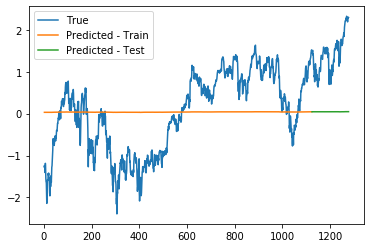

Epochs:  10  Iterations:  825  Loss:  0.03612472527660429


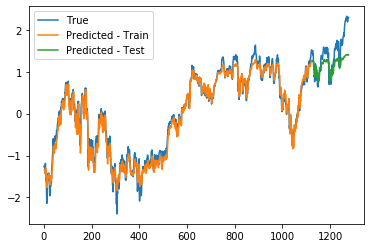

Epochs:  20  Iterations:  1575  Loss:  0.032195940284679335


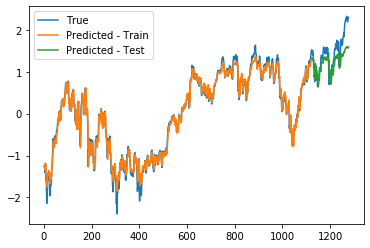

Epochs:  30  Iterations:  2325  Loss:  0.03118569526510934


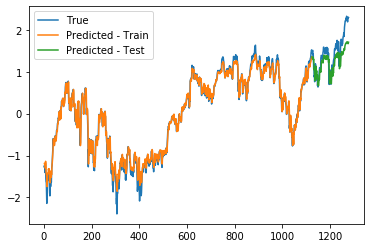

Epochs:  40  Iterations:  3075  Loss:  0.03059123467033108


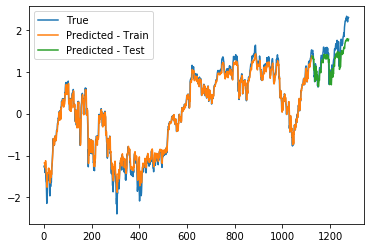

Epochs:  50  Iterations:  3825  Loss:  0.03012367507753273


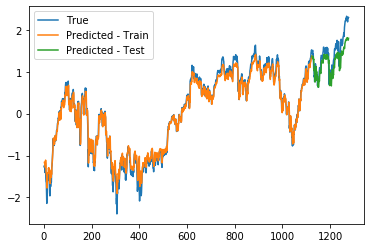

Epochs:  60  Iterations:  4575  Loss:  0.02981819131722053


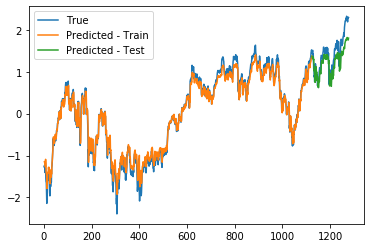

Epochs:  70  Iterations:  5325  Loss:  0.0296978861776491


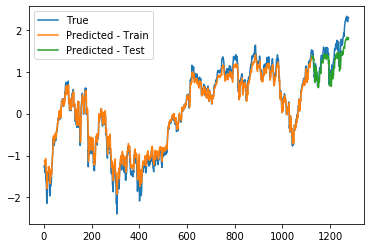

Epochs:  80  Iterations:  6075  Loss:  0.029712547638143103


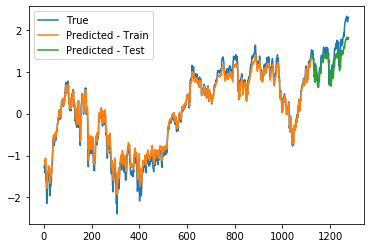

Epochs:  90  Iterations:  6825  Loss:  0.029742372628922265


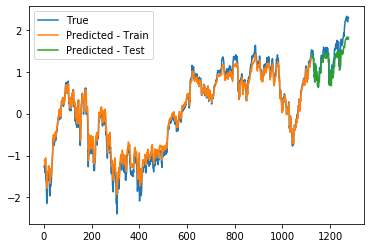

Epochs:  100  Iterations:  7575  Loss:  0.0296417595166713


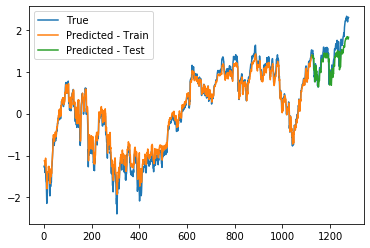

Finished Training


In [0]:

# Initialize model
print("==> Initialize DA-RNN model ...")
model = DA_rnn(
    X,
    y,
    ntimestep,
    nhidden_encoder,
    nhidden_decoder,
    batchsize,
    lr,
    epochs
)

# Train
print("==> Start training ...")
model.train()

# Prediction
y_pred = model.test()

fig1 = plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.savefig("1.png")
plt.close(fig1)

fig2 = plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.savefig("2.png")
plt.close(fig2)
fig3 = plt.figure()
plt.plot(y_pred, label='Predicted')
plt.plot(model.y[model.train_timesteps:], label="True")
plt.legend(loc='upper left')
plt.savefig("3.png")
plt.close(fig3)
print('Finished Training')

In [0]:
(y_pred-model.y[model.train_timesteps:])

array([-4.17641587e-02, -9.06447989e-02, -1.49821452e-01, -1.44499117e-01,
       -1.98549213e-02, -3.23070414e-02,  3.81610285e-02,  2.62364001e-01,
        8.99365830e-02,  1.64537277e-01,  1.80324193e-01,  1.15801911e-01,
       -3.21464820e-02, -2.54771071e-01, -2.49457888e-01, -1.54204217e-01,
        1.71117519e-01,  9.06013578e-02, -6.15570013e-02,  2.21449397e-01,
        1.28339144e-01, -1.21978817e-01,  5.91156993e-04,  2.51963837e-01,
        1.42012470e-01,  3.89125819e-02,  2.45706575e-02, -1.29218478e-01,
       -1.12913657e-01, -2.44496159e-02, -1.68456223e-01, -2.38418400e-01,
       -1.21679555e-01, -6.82033074e-03,  4.67598240e-02,  2.97934543e-04,
       -5.24400685e-02, -3.41960626e-01, -3.11249747e-01, -1.23099589e-01,
       -9.56598898e-02, -4.77128169e-02, -4.18779259e-02, -1.83536091e-02,
       -1.97306998e-02, -1.50606240e-01, -2.25915435e-01, -1.65382887e-01,
       -2.13108810e-01, -2.01434335e-01, -7.41643425e-02, -6.04226991e-02,
       -6.56783291e-02, -

In [0]:
from sklearn.metrics import mean_squared_error
y_test = model.y[model.train_timesteps:]
mean_squared_error(y_test, y_pred)


0.05947654739148564

In [0]:
from sklearn.metrics import r2_score
forecast_errors = np.array([y_test[i]-y_pred[i] for i in range(len(y_test))])
mean_forecast_error = np.mean(forecast_errors)
print('Forecast Errors: %s' % forecast_errors)
print('Mean Forecast Error: %s' % np.round(mean_forecast_error,2))
print('Mean Absolute Forecast Error: %s' % np.round(np.mean(abs(forecast_errors)),2))
print('R^2 Score: %s' % np.round(r2_score(y_test, y_pred),2))

Forecast Errors: [ 4.17641587e-02  9.06447989e-02  1.49821452e-01  1.44499117e-01
  1.98549213e-02  3.23070414e-02 -3.81610285e-02 -2.62364001e-01
 -8.99365830e-02 -1.64537277e-01 -1.80324193e-01 -1.15801911e-01
  3.21464820e-02  2.54771071e-01  2.49457888e-01  1.54204217e-01
 -1.71117519e-01 -9.06013578e-02  6.15570013e-02 -2.21449397e-01
 -1.28339144e-01  1.21978817e-01 -5.91156993e-04 -2.51963837e-01
 -1.42012470e-01 -3.89125819e-02 -2.45706575e-02  1.29218478e-01
  1.12913657e-01  2.44496159e-02  1.68456223e-01  2.38418400e-01
  1.21679555e-01  6.82033074e-03 -4.67598240e-02 -2.97934543e-04
  5.24400685e-02  3.41960626e-01  3.11249747e-01  1.23099589e-01
  9.56598898e-02  4.77128169e-02  4.18779259e-02  1.83536091e-02
  1.97306998e-02  1.50606240e-01  2.25915435e-01  1.65382887e-01
  2.13108810e-01  2.01434335e-01  7.41643425e-02  6.04226991e-02
  6.56783291e-02  5.95532245e-02  5.17287463e-02  1.10953268e-01
  1.47111045e-01  1.94014878e-01  8.98829201e-02 -2.22233891e-02
  5.2550

In [0]:
whos

Variable              Type            Data/Info
-----------------------------------------------
DA_rnn                type            <class '__main__.DA_rnn'>
Decoder               type            <class '__main__.Decoder'>
Encoder               type            <class '__main__.Encoder'>
F                     module          <module 'torch.nn.functio<...>/torch/nn/functional.py'>
Variable              VariableMeta    <class 'torch.autograd.variable.Variable'>
X                     ndarray         1277x12: 15324 elems, type `float64`, 122592 bytes (119.71875 kb)
X_mean                float64         76.68257665387625
X_std                 float64         72.20961523231084
batchsize             int             15
dataroot              str             join2.csv
df                    DataFrame                   Date  Close_V<...>n[1277 rows x 14 columns]
drive                 module          <module 'google.colab.dri<...>s/google/colab/drive.py'>
epochs                int             110


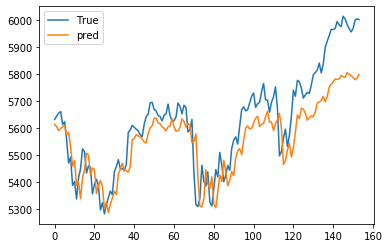

In [0]:
plt.plot(y_test*y_std+y_mean, label="True")
plt.plot(y_pred*y_std+y_mean, label="pred")
plt.legend()
plt.show()

In [0]:
from torchsummary import summary
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print(model)
print("Number of parameters : ",get_n_params(model))

#summary(model, input_size=(12, 1277, 1))

DA_rnn(
  (Encoder): Encoder(
    (encoder_lstm): LSTM(24, 16)
    (encoder_attn): Linear(in_features=33, out_features=1, bias=True)
  )
  (Decoder): Decoder(
    (attn_layer): Sequential(
      (0): Linear(in_features=48, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
    (lstm_layer): LSTM(1, 16)
    (fc): Linear(in_features=17, out_features=1, bias=True)
    (fc_final): Linear(in_features=32, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
Number of parameters :  4790


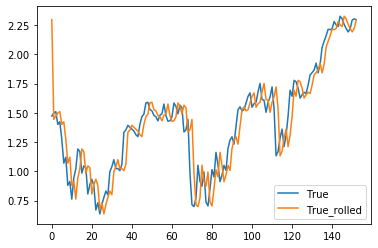

In [0]:
y_roll=np.roll(y_test,2)
y_roll[0]=0
mean_squared_error(y_test[1:], y_roll[1:])
plt.plot(y_test[1:], label='True')
plt.plot(y_roll[1:], label='True_rolled')
plt.legend()
plt.show()

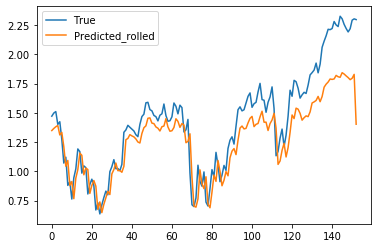

In [0]:
y_roll=np.roll(y_pred,-1)
y_roll[0]=0
mean_squared_error(y_test[1:], y_roll[1:])
plt.plot(y_test[1:], label='True')
plt.plot(y_roll[1:], label='Predicted_rolled')
plt.legend()
plt.show()